# EMDOT Tutorial

This tutorial, based off the "Evaluating Model Performance in Medical Datasets Over Time" paper, explains how users can apply the EMDOT framework to evaluate their own models on their own datasets and prediction tasks of interest.

## Import libraries

To start, we import various components of the emdot package. In order to install the emdot package, do the following:

```
conda create --name <env_name> python==3.8.3
conda activate <env_name>

git clone https://github.com/acmi-lab/EvaluationOverTime.git
cd EvaluationOverTime/src
pip install .
```

To make the above environment available to your jupyter notebook, run:
`python -m ipykernel install --user --name=<env_name>`

In [4]:
from emdot.eot_experiment import EotExperiment
from emdot.example_datasets import get_toy_breast_cancer_data
from emdot.models.LR import LR
from emdot.models.GBDT import GBDT
from emdot.models.MLP import MLP
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from emdot.utils import plot_metric_vs_time

## Quick Start

First, we walk through a simple example of how users can set up an experiment to evaluate model performance over time using the following default options: 
* dataset: toy breast cancer data
* task: binary classification 
* models: logistic regression, gradient boosted decision trees, and feed forward neural networks
* metrics: AUC, AUPRC, F1 score, accuracy
* visualizations: model performance over time (Figure 3 in paper)

Note: while the medical datasets in the paper are easily accessible by researchers after signing data use agreements, unfortunately we cannot re-release the medical data itself in our package.

In later sections, we will describe how users can **customize** each of these defaults to datasets, models, metrics, tasks, and visualizations of their preference.

### 0) Preliminaries

As in any typical machine learning experiment, we must specify: 

0. Experiment parameters (max iterations, number of seeds, etc.)

1. The dataset (assumed to be pre-processed and ready for inference, save for numerical variables which we normalize in the framework using the relevant training set).

2. The model class of in interest and its hyperparameter search space

In [3]:
max_iter = 500
training_regime = 'sliding_window'
seed_num = 3
seed_list = list(range(seed_num))

model_name = 'LR'

dataset_name = 'toy_data'
label = 'target'
training_regime = 'sliding_window'

# retrieve the (mostly) preprocessed dataset 
#  (note: numerical values do not have to be normalized
#  since the scaling/offsets depend on the training set)
df, col_dict = get_toy_breast_cancer_data()

# select the desired model and hyperparameters
models = {
    "LR": {
        "model_class": LR,
        "search_space": {
            "C": [10.0**e for e in np.arange(-2, 5)],
        }
    },
    "GBDT": {
        "model_class": GBDT,
        "search_space": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "learning_rate": [0.01, 0.1],
        }
    },
    "MLP": {
        "model_class": MLP,
        "search_space": {
            "hidden_layer_sizes": [(3,), (5,)],
            "learning_rate_init": [0.0001, 0.001, 0.01],
        }
    }  
}
model_class = models[model_name]['model_class']
hyperparam_grid = models[model_name]['search_space']
hyperparam_grid['max_iter'] = [max_iter]

### 1) Create an EotExperiment object

Here, users can specify:
1. `dataset_name`: (`str`) name of dataset, used for display purposes only.
2. `df`: (`DataFrame`) pre-processed dataframe, which includes all of the columns mentioned in col_dict. All categorical variables should be converted to dummies, however numerical features do not need to be normalized. This is to ensure that the same scaling factors and offsets from the training data are applied to the validation and test sets.
3. `col_dict`: (`dict`) dictionary of the following format:

    {
        "numerical_features": ['numerical_col1', 'numerical_col2', ...],
        "all_features": ['feature_col1', 'feature_col2', ...],
        "label_cols": ['label_col1', 'label_col2', ...],
        "time_col": "Year of diagnosis",
        "ID": "Patient ID"
    }

    Descriptions of each key:value pair are below: 
    * `"numerical_features"`: names of all numerical features
    * `"all_features"`: names of all features in df, including numerical features; make sure to exclude outcomes
    * `"label_cols"`: names of column(s) corresponding to label
    * `"time_col"`: name of column corresponding to timestamp (year, month, etc.)
    * `"ID"`: unique identifier for each patient
4. `label`: (`str`) name of the column in the dataframe to be used as the label (e.g. "mortality", "MORTALITY_180D")
5. `model_class`: (`ExpModel` object) model class to evaluate. Should implement the models.ExpModel interface.
6. `model_name`: (`str`) name of model class (e.g. "LR", "GBDT"), used for display purposes only.
7. `hyperparam_grid`: (`dict`) dictionary containing grid of hyperparameters to search over (e.g. {"C": [0.01, 0.1, 1]})
8. `training_regime`: (`str`) training regime to use in evaluation of performance over time (e.g. "all_historical", "sliding_window", "all_historical_subsampling")
9. `initial_train_window`: (`tuple`) tuple with the first timepoint and last timepoint (inclusive) of the FIRST in-sample time window to be used for training (e.g. (1975, 1978) would be a four-year time range.)
The oldest model is trained on data in this time range, and subsequent models are trained on newer data.
10. `train_end`: (`int` or `float`) the latest timepoint of the entire in-sample time range.
11. `test_end`: (`int` or `float`) the latest timepoint of the entire out-of-sample time range
12. `train_prop`: (`float`) proportion of in-sample data to use as training set.
13. `val_prop`: (`float`) proportion of in-sample data to use as validation set.
14. `test_prop`: (`float`) proportion of in-sample data to use as test set.
15. `window_length`: (`int`) number of timepoints in sliding window. If doing sliding window evaluation: should equal train_end_t - train_start_t + 1. If doing subsampling with all-historical: this is used to compute the number of samples to subsample so that it is comparable to the sliding window evaluation. Thus, set window_length to be the same as used in sliding window evaluation.
16. `time_unit`: (`str`) unit of time that timepoints are in. used for display purposes only.
17. `model_folder`: (`str`) path to folder to save trained models. If None, models will not be saved.

In [4]:
experiment = EotExperiment(
    dataset_name = dataset_name,
    df = df, 
    col_dict = col_dict, 
    label = label,
    model_class = model_class,
    model_name = model_name,
    hyperparam_grid = hyperparam_grid,
    training_regime = training_regime,
    initial_train_window = (0, 4),
    train_end = 7,
    test_end = 9,
    train_prop = 0.5,
    val_prop = 0.25,
    test_prop = 0.25,
    window_length = 5,
    time_unit = 'Year',
    model_folder = './model_info')

### 2) Run the EotExperiment

Here we run the EotExperiment specified in the previous cell, and store the results for future analysis.

In [5]:
result_df, model_info = experiment.run_experiment(seed_list, eval_metric="auc")

## Generate name of result
result_name = f"{dataset_name}_{max_iter}_{label}_{model_name}_{seed_num}_{training_regime}.csv"

# make results folder if not exists
result_folder = f'result/{model_name}/{dataset_name}'
if not os.path.exists('result'):
    os.makedirs(result_folder)

## Store result as csv file
result_df.to_csv(f"./{result_folder}/{result_name}")

## Store feature coefficients if available
if model_name == "LR":
    model_info.to_csv(f"./model_info/{model_name}/{dataset_name}/{result_name}")


Train {self.time_unit}:   0%|                                                                   | 0/4 [00:00<?, ?it/s]

Hyperparameters:   0%|                                                                          | 0/7 [00:00<?, ?it/s]

Hyperparameters:  86%|████████████████████████████████████████████████████████▌         | 6/7 [00:00<00:00, 53.33it/s]

                                                                                                                      

Test Year:   0%|                                                                                | 0/5 [00:00<?, ?it/s]

                                                                                                                      
Train {self.time_unit}:  25%|██████████████▊                                            | 1/4 [00:00<00:00,  3.30it/s]

Hyperparameters:   0%|                                                                          | 0/7 [00:00<?, ?it/s]

                                         

In [6]:
result_df.head()

,model,test_type,train_start,train_end,test_start,test_end,auc,auprc,acc,f1,dataset_name,seed,train_size,val_size,test_size,best_hparams,staleness
0,LR,insample,0,4,4,4,1.000000,1.000000,0.928571,0.952381,toy_data,0,145,72,14,"{'C': 10.0, 'max_iter': 500}",0
1,LR,outsample,0,4,5,5,1.000000,1.000000,0.979592,0.981132,toy_data,0,145,72,49,"{'C': 10.0, 'max_iter': 500}",1
2,LR,outsample,0,4,6,6,1.000000,1.000000,1.000000,1.000000,toy_data,0,145,72,59,"{'C': 10.0, 'max_iter': 500}",2
3,LR,outsample,0,4,7,7,1.000000,1.000000,1.000000,1.000000,toy_data,0,145,72,55,"{'C': 10.0, 'max_iter': 500}",3
4,LR,outsample,0,4,8,8,0.953177,0.955384,0.935484,0.950000,toy_data,0,145,72,62,"{'C': 10.0, 'max_iter': 500}",4


In [7]:
len(model_info)

12

In [8]:
model_info

,train_start,train_end,seed,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,timept,Patient ID
0,0,4,0,0.074603,-0.022600,0.151544,0.001693,0.149052,0.827510,-1.339629,...,-0.909053,-1.405757,-0.799533,-0.156177,-1.210648,-1.856670,-1.361709,0.883047,-0.737971,-0.633060
1,1,5,0,-0.241772,-0.265468,-0.241629,-0.222536,0.036384,-0.063568,-0.245585,...,-0.356223,-0.310855,-0.170885,-0.201856,-0.286401,-0.361520,-0.294467,-0.204611,-0.133085,-0.241711
2,2,6,0,-0.126060,-0.098740,-0.123674,-0.119694,-0.051672,-0.054803,-0.099886,...,-0.135401,-0.130127,-0.108303,-0.092874,-0.121300,-0.139633,-0.090678,-0.067977,-0.073663,-0.057685
3,3,7,0,-0.127344,-0.087594,-0.128967,-0.122624,-0.053949,-0.076698,-0.125474,...,-0.133381,-0.116576,-0.088359,-0.103330,-0.141746,-0.153476,-0.102103,-0.054024,-0.070149,-0.054288
4,0,4,1,-0.583790,-0.512734,-0.564531,-0.486584,0.068982,-0.241082,-0.612256,...,-0.751668,-0.623722,-0.539173,-0.193689,-0.286149,-0.745181,-0.206581,-0.598050,-0.665791,-0.437295
5,1,5,1,-0.275299,-0.174056,-0.269412,-0.251336,-0.067628,-0.046895,-0.234079,...,-0.355455,-0.313947,-0.208242,-0.201277,-0.286206,-0.371526,-0.326770,-0.082783,-0.216299,-0.080157
6,2,6,1,-0.239240,-0.188187,-0.228237,-0.228704,-0.075013,-0.023111,-0.169992,...,-0.317794,-0.304578,-0.221767,-0.191206,-0.314680,-0.373599,-0.360617,-0.141759,-0.165120,-0.194306
7,3,7,1,-0.331733,-0.202204,-0.311663,-0.345617,-0.177524,0.173002,-0.476518,...,-0.541848,-0.573293,-0.902372,0.173079,-0.694108,-0.841077,-0.586867,-0.167649,-0.418524,-0.455343
8,0,4,2,-0.123526,-0.107426,-0.123572,-0.105113,-0.041301,-0.078009,-0.117715,...,-0.136206,-0.116118,-0.087313,-0.094405,-0.132889,-0.153527,-0.096798,-0.039223,-0.071114,-0.062971
9,1,5,2,-0.407431,-0.451108,-0.401817,-0.402075,-0.056665,0.067653,-0.558175,...,-0.815156,-0.751668,-0.506049,-0.474629,-0.526438,-0.668846,-0.675805,-0.776891,-0.122389,-0.132794


### 3) Visualize results

Here we visualize the performance of models trained until each point in time, with test AUCs evaluated on all future points in time.

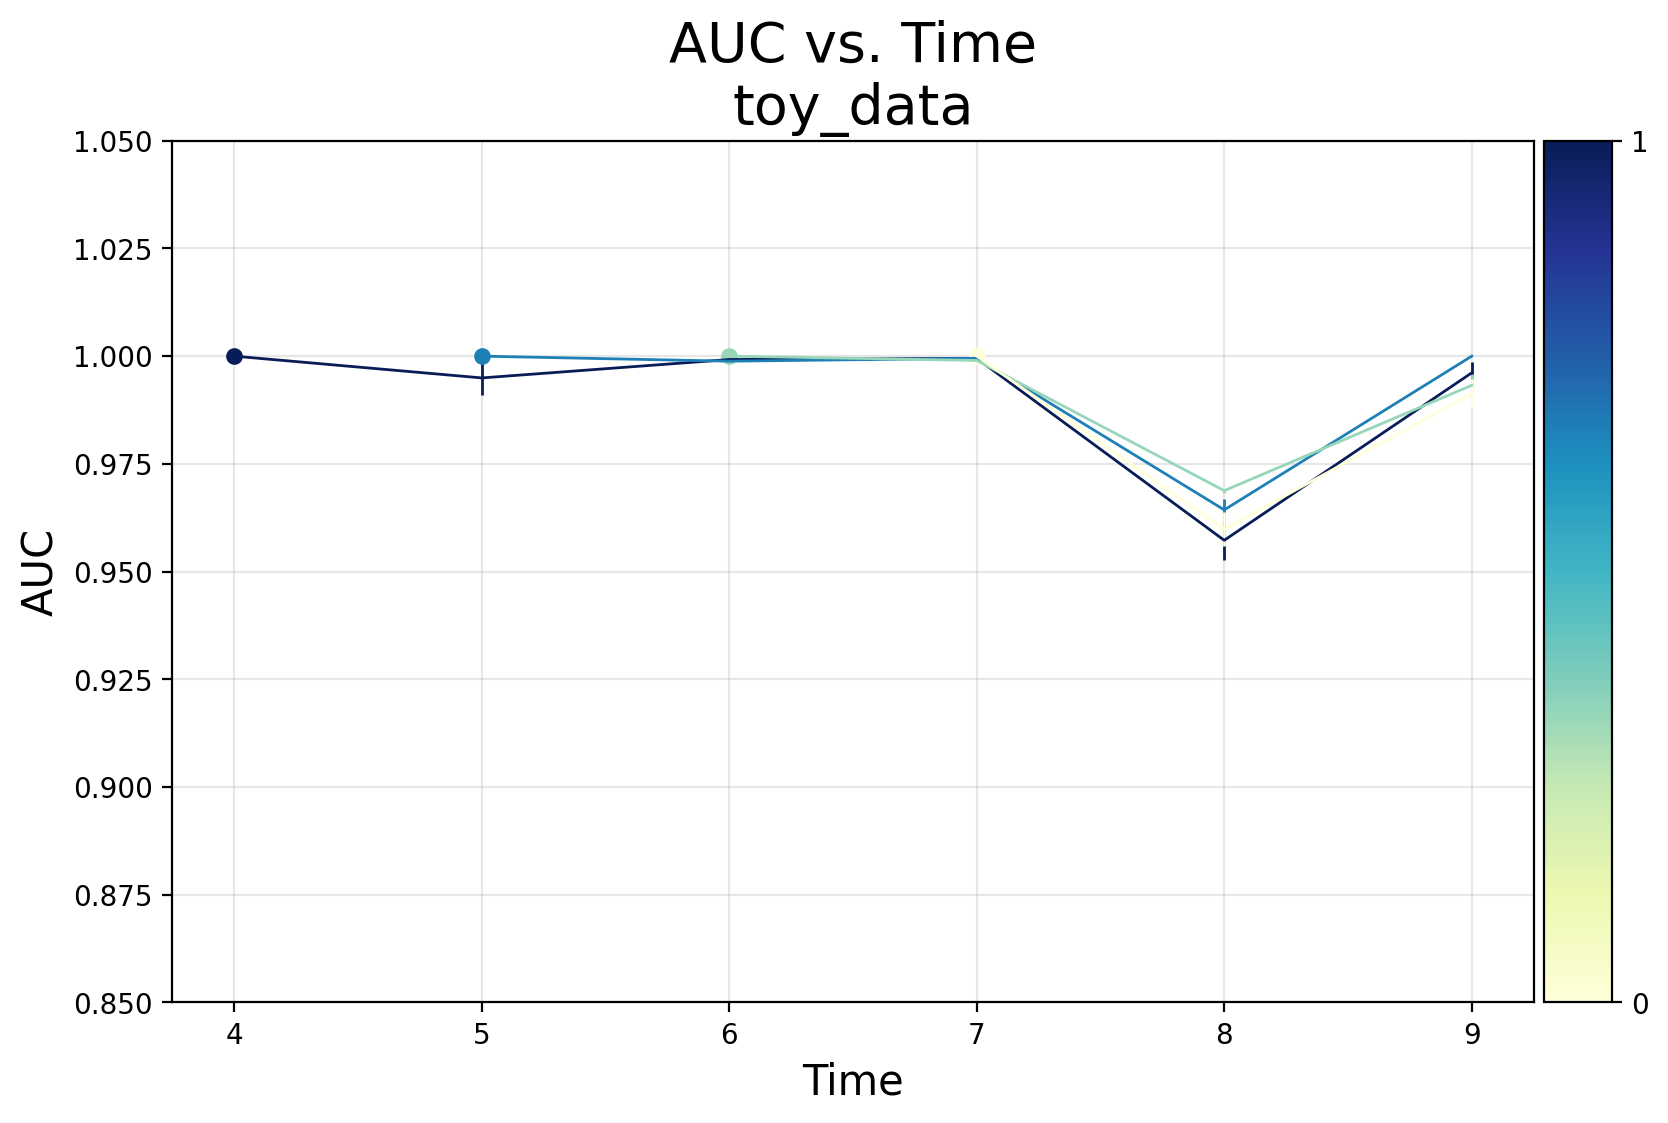

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figsize = (8, 5.5)
dpi = 200

fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, constrained_layout=True)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plot_metric_vs_time(result_df, "auc", dataset_name, fig, ax, cax=cax, ylim=(0.85, 1.05), 
#                     figsize=(5, 3), 
                    cus_x=[4, 5, 6, 7, 8], xlabel="Time")
plt.show()

# Customization

Here, we describe how users can easily plug in their own datasets, tasks, models, metrics, visualizations, and tasks. To summarize:

1. Custom datasets and tasks: in the `EotExperiment` object, simply replace the `dataset_name`, `label`, `df`, `col_dict`, `train_end`, `test_end`, and `time_unit` according to your preferences for the dataset and task of interest.

2. Custom models: implement the `ExpModel` abstract class. This just requires you to define `fit()` and `evaluate()` functions for your model.

3. Custom metrics: in your `ExpModel`, return the metrics of interest in a dictionary in the `evaluate()` function.

4. Custom visualizations: the `run_experiment()` function of the `EotExperiment` class returns: 

    * `result_df`: dataframe containing test performance metrics of each model trained up to each time point, and evaluated on subsequent time points. Additionally includes the test performance evaluated on the latest in-sample time point. 
    * `model_info`: dataframe containing coefficients of every model
    
    These dataframes can then be visualized using standard plotting packages such as `matplotlib`. By default, we include in `emdot.utils` a `plot_metric_vs_time()` function. The plots in the paper can be recreated from `result_df` and `model_info` using the code available in `EMDOT_custom/`.


### 1) Custom Datasets

In [10]:
custom_dataset_name = "custom_dataset"

### Multiple labels due to more than one interesting prediction tasks given a dataset
df_custom = pd.DataFrame({
    'custom_patient_identification': np.ones(10),
    'custom_feature1': np.ones(10),
    'custom_feature2': np.ones(10),
    'custom_feature3': np.ones(10),
    'custom_timestamp': np.arange(10),
    'custom_label_1': np.random.randint(2, size=10),
    'custom_label_2': np.random.randint(2, size=10)
})

### For example, one may choose custom_label_1 for prediction task
custom_label = "custom_label_1"

col_dict = {
    "processed_numerical_feature": ["custom_feature1"],
    "processed_all_feature": ["custom_feature1", "custom_feature2", "custom_feature3"],
    "processed_label": ["custom_label_1", "custom_label_2"],
    "year_label": "custom_timestamp",
    "ID": "custom_patient_identification"
}

custom_train_end = 8
custom_test_end = 9
custom_time_unit = "year"


### 2, 3) Custom Models & Custom metrics

In [13]:
from emdot import ExpModel

class CustomModel(ExpModel):
    def __init__(self, custom_var1, custom_var2):
        super().__init__()
        self.custom_var1 = custom_var1
        self.custom_var2 = custom_var2

        self.custom_model = ### Model implementation

    def fit(self, X_train, y_train):
        ### Custom training process. A general example is shown below:
        for epoch in range(num_iter):
            self.custom_model.train_epoch()
    
    def evaluate(self, X_test, y_test):
        ### Prediction on test data
        y_pred = self.custom_model.predict(X_test)
        
        custom_metric_1 = custom_evaluation_1(y_test, y_pred)
        custom_metric_2 = custom_evaluation_2(y_test, y_pred)
        custom_metric_3 = custom_evaluation_3(y_test, y_pred)

        return {
            "custom_metric_1_name": custom_metric_1,
            "custom_metric_2_name": custom_metric_2,
            "custom_metric_3_name": custom_metric_3
        }

### 4) Custom visualization

In [14]:
from emdot.utils import plot_metric_vs_time

### Call run_experiment() and get result_df, model_info
result_df, model_info = custom_eot_experiment.run_experiemnt()

### Performance over time visualization (with custom_metric_1)
custom_fig, custom_ax = plt.subplots(1, 1)
plot_metric_vs_time(result_df, custom_metric_name_1, custom_dataset_name, custom_fig, custom_ax)